In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from datasets import TripletMNIST

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from networks import EmbeddingNet, TripletNet
from torchvision.datasets import ImageFolder
from losses import TripletLoss
from metrics import AccumulatedAccuracyMetric
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor

In [26]:
dataset = ImageFolder("../data/teacher_data/Dishes", transform=ToTensor())

In [9]:
len(dataset)

9000

In [10]:
from torch.utils.data import random_split

test_size = 0.2
test_n_samples = int(len(dataset)*test_size)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_n_samples, test_n_samples])

In [11]:
len(val_dataset)

1800

In [12]:
cuda = torch.cuda.is_available()

In [8]:
import numpy as np

In [9]:
train_dataset.dataset

Dataset ImageFolder
    Number of datapoints: 9000
    Root location: ../data/teacher_data/Dishes

In [13]:
from torch.utils.data import random_split



test_size = 0.2
test_n_samples = int(len(dataset)*test_size)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_n_samples, test_n_samples])

triplet_dataset_train = TripletMNIST(train_dataset.dataset, train=True, subset_indices=train_dataset.indices) 
triplet_dataset_val = TripletMNIST(val_dataset.dataset, train=False, subset_indices=val_dataset.indices)
# triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_dataset_train, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_dataset_val, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)

if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
log_interval = 100

In [11]:
fit(triplet_train_loader, triplet_test_loader,  model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)#, metrics=[AccumulatedAccuracyMetric()])

: 

In [ ]:
for batch_idx, (data, target) in enumerate(triplet_test_loader):
    print((data[0].shape))
    break

In [26]:
for batch_idx, (data, target) in enumerate(triplet_train_loader):
    print((data[2]).shape)
    break

torch.Size([128, 3, 224, 224])


In [24]:
data[0].view(data[0].size(0),-1).shape

torch.Size([3, 50176])

In [14]:
embedding_test = EmbeddingNet()
embedding_test(data[0])

torch.Size([64, 53, 53])
torch.Size([64, 2809])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2809 and 179776x256)

In [14]:
3392*53

179776

In [34]:
model = torch.load("../model.pt")

In [35]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [36]:
for images, target in train_loader:
            if cuda:
                images = images.cuda()
            test = model.get_embedding(images).data.cpu().numpy()
            break

In [37]:
test.shape

(128, 2)

In [38]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

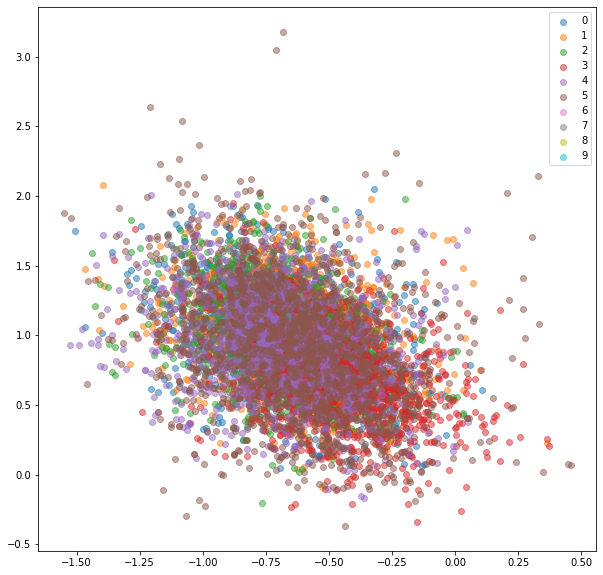

In [39]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
# val_embeddings_tl, val_labels_tl = extract_embeddings(triplet_test_loader, model)
# plot_embeddings(val_embeddings_tl, val_labels_tl)